In [ ]:
!pip install -q -U google-generativeai

In [ ]:
import pathlib
import textwrap

import google.generativeai as genai

from google.colab import userdata

from IPython.display import display
from IPython.display import Markdown

In [ ]:
# GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key="GOOGLE_API_KEY")

In [ ]:
json_data = json.load(open("curelink.json"))

In [ ]:
final_output = []

## The below cell contains functions which are made for the purpose of getting recommended meal from the meal_options using date, time and id.

Instead of using PDF OCR to read the charts which may incurr cost and time, I used the chart diet data provided in the json by using the query date and time which is nearest to the diet time.

In [ ]:
import json
from datetime import datetime, timedelta
from bs4 import BeautifulSoup


# Function to calculate the order based on start_date and input date
def calculate_order(start_date, input_date):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    input_d = datetime.strptime(input_date, "%Y-%m-%d")
    return (input_d - start).days + 1

# Function to find the nearest meal time
def find_nearest_meal_time(meal_times, input_time):
    input_dt = datetime.strptime(input_time, "%I:%M %p")
    nearest_time = min(meal_times, key=lambda x: abs(datetime.strptime(x, "%I:%M %p") - input_dt))
    return nearest_time

# Function to extract the required details
def extract_meal_details(json_file, diet_chart_id, input_time, date):

    for entry in json_data:
        diet_chart = entry.get("profile_context", {}).get("diet_chart", {})
        if diet_chart.get("id") == diet_chart_id:
            start_date = diet_chart.get("start_date", "").split("T")[0]
            order = calculate_order(start_date, date)
            meals_by_days = diet_chart.get("meals_by_days", [])

            for day in meals_by_days:
                if day.get("order") == order:
                    meals = day.get("meals", [])
                    meal_times = [meal.get("timings") for meal in meals]
                    nearest_time = find_nearest_meal_time(meal_times, input_time)

                    for meal in meals:
                        if meal.get("timings") == nearest_time:
                            meal_options = meal.get("meal_options", [])
                            food_items_details = []

                            for option in meal_options:
                                notes = option.get("notes", "")
                                soup = BeautifulSoup(notes, "html.parser")
                                plain_text = soup.get_text()
                                for item in option.get("meal_option_food_items", []):
                                    food_name = item.get("Food", {}).get("name")
                                    food_measure_quantity = item.get("food_measure_quantity")
                                    food_measures = item.get("Food", {}).get("food_measures", [])
                                    food_measure_name = next(
                                        (measure.get("name") for measure in food_measures if measure.get("rank") == 1), ""
                                    )
                                    food_items_details.append(f"{food_name} ({food_measure_quantity} {food_measure_name})")

                            return ', '.join(food_items_details) + "\n" + plain_text

    return "No matching details found."

## The below cell is to iterate over the latest_query with images and chat_context.

In [ ]:
def process_latest_query(latest_query, chat_context):
    result = {}

    # Create a dictionary to map messages to asset_urls from chat_history
    message_to_asset_url = {}
    for chat in chat_context.get("chat_history", []):
        message = chat.get("message", "")
        asset_url = chat.get("asset_url", "")
        if message and asset_url:
            message_to_asset_url[message] = asset_url

    for query in latest_query:
        if query.get("role") == "user":
            content = query.get("content", "")

            if content.startswith("Sent an image"):
                description = content

                # Find the matching asset_url based on the full content
                image_url = message_to_asset_url.get(description, description)

                caption = ""

                # Check if there's a caption starting with "with the following caption"
                if "with the following caption" in content:
                    caption_start = content.find("with the following caption") + len("with the following caption")
                    caption = content[caption_start:].strip()

                # Or if there's a caption starting with "with:\""
                elif "with: \"" in content:
                    caption_start = content.find("with: \"") + len("with: \"")
                    caption_end = content.find("\"", caption_start)
                    caption = content[caption_start:caption_end].strip()

                # Store the URL (asset_url or default description) and caption in the dictionary
                result[image_url] = caption

            elif content.startswith("Replied to the following message"):
                # Extract the referenced description (message)
                msg_start = content.find("\"") + 1
                msg_end = content.find("\"", msg_start)
                referenced_msg = content[msg_start:msg_end].strip()

                # Extract the reply content after "with:\""
                reply_start = content.find("with: \"") + len("with: \"")
                reply_end = content.find("\"", reply_start)
                reply = content[reply_start:reply_end].strip()

                # Find the asset_url for the referenced message
                referenced_url = message_to_asset_url.get(referenced_msg, None)

                if referenced_url in result:
                    result[referenced_url] = reply

    return result

The final loop to iterate over json and call all the functions and Gemini LLM to perform AI task.

In [ ]:
for item in json_data:
  latest_query_data=item["latest_query"]
  chat_context_data=item["chat_context"]
  ticket_id = item["chat_context"]["ticket_id"]
  ideal_response = item["ideal_response"]
  ticket_created= item["chat_context"]["ticket_created"]
  dt = datetime.strptime(ticket_created, "%B %d, %Y, %I:%M %p")
  input_time = dt.strftime("%I:%M %p")
  date = dt.strftime("%Y-%m-%d")
  diet_chart_id = item["profile_context"]["diet_chart"]["id"]

  meal_details = extract_meal_details('curelink.json', diet_chart_id, input_time, date)

  latest_query_dict = process_latest_query(latest_query_data,chat_context_data)
  sample_file = ["Diet: "+meal_details+"\n"]
  for the_key, the_value in latest_query_dict.items():
    !curl -s -o user_input.jpg {the_key}
    sample_image = genai.upload_file(path="user_input.jpg")
    sample_file.append(sample_image)
    sample_file.append(the_value)

  model = genai.GenerativeModel(
      'gemini-1.5-flash',
      system_instruction="You're a dietician who have given some diet plans for user which is needed to follow strictly, your users send you a picture on whatsapp whenever they eat. Your job is to check if they're following the Diet strictly or not.")

  response = model.generate_content(sample_file,safety_settings={
          'HATE': 'BLOCK_NONE',
          'HARASSMENT': 'BLOCK_NONE',
          'SEXUAL' : 'BLOCK_NONE',
          'DANGEROUS' : 'BLOCK_NONE'
      })

  final_response = {
	  "ticket_id": ticket_id,
	  "latest_query":latest_query_data,
	  "generated_response": response.text,
	  "ideal_response": ideal_response
  }

  final_output.append(final_response)

In [ ]:
file_name = 'output.json'
with open(file_name, 'w') as file:
    json.dump(final_output, file, indent=4)

## Note: As the task specifically focuses on Images but some queries doesn't contain any, hence Gemini may come up with some junk responses or only reply to images not texts.

Note: Some of the ideal responses provided doesn't matches with the user's query. But the generated responses performs better.

An example of the same is: 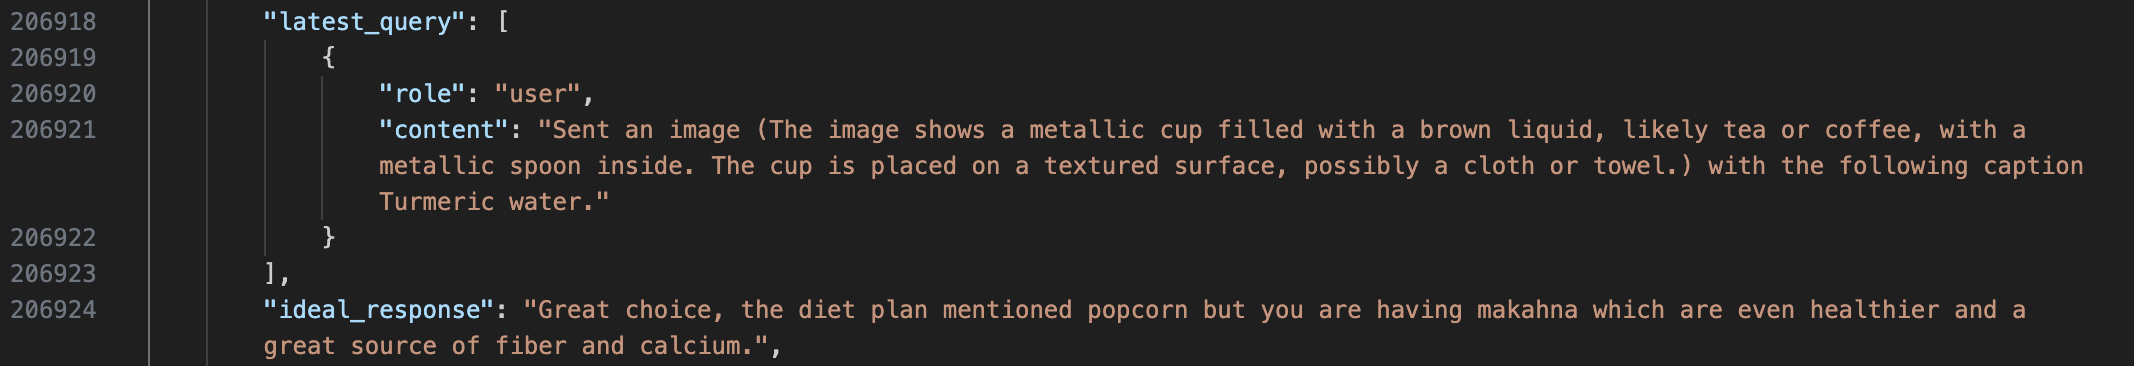

You can seein above, the ideal response doesn't matches with the user query.